In [2]:
import numpy as np
from numpy.random import SeedSequence
from matplotlib import pyplot as plt
import tigramite
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.toymodels.context_model import ContextModel
from tigramite.jpcmciplus import JPCMCIplus
from tigramite.independence_tests.parcorr_mult import ParCorrMult
import tigramite.data_processing as pp
import tigramite.plotting as tp
import torch
import pandas as pd

In [3]:
loaded_data = torch.load('full_tensor.pt')
if isinstance(loaded_data, torch.Tensor):
    numpy_array = loaded_data.numpy()
    if loaded_data.is_cuda:
        numpy_array = numpy_array.copy()
array_dict = {index: row for index, row in enumerate(numpy_array)}
series_data = pd.read_csv('dv_median.csv', header = None)
series_data = pd.concat([series_data] * 306, ignore_index=True)

{0: array([[ 6.6216728e+01,  7.8297436e-02,  2.9213718e+02, ...,
         1.0428891e+01, -1.7086846e-05,  9.0209961e-01],
       [ 6.5442093e+01,  6.4270504e-02,  2.9220340e+02, ...,
         1.0456808e+01, -1.6913484e-05,  8.8403320e-01],
       [ 6.2176434e+01,  4.7262765e-02,  2.9225165e+02, ...,
         1.0514570e+01, -1.6210168e-05,  8.9477539e-01],
       ...,
       [ 8.2953362e+01,  5.0869898e-04,  2.9781079e+02, ...,
         5.8437805e+00,  5.1478673e-07,  2.4536133e-01],
       [ 6.5298058e+01,  4.2482399e-04,  2.9785562e+02, ...,
         5.8070326e+00,  1.3482295e-06,  2.2485352e-01],
       [ 6.1132053e+01,  5.0668191e-04,  2.9789850e+02, ...,
         5.7648726e+00,  3.0177080e-06,  2.3657227e-01]], dtype=float32), 1: array([[ 2.0073140e+02,  7.9934401e-03,  2.9514661e+02, ...,
         8.2448788e+00, -1.1175974e-06,  9.3383789e-01],
       [ 2.0304538e+02,  1.0846393e-02,  2.9522073e+02, ...,
         8.2268219e+00, -1.4466661e-06,  9.3188477e-01],
       [ 2.1910576e+

In [53]:
import numpy as np
import pandas as pd
for d in array_dict:
    arr = array_dict[d]
    new = np.zeros((144, 9))
    for i in range(len(arr)):
        element = series_data.iloc[0]
        new_arr = np.append(arr[i], element)
        series_data = series_data.drop(series_data.index[0])
        new[i] = new_arr
    array_dict[d] = new
print(array_dict[0])


[[ 6.62167282e+01  7.82974362e-02  2.92137177e+02 ... -1.70868461e-05
   9.02099609e-01 -2.10153754e-01]
 [ 6.54420929e+01  6.42705038e-02  2.92203400e+02 ... -1.69134837e-05
   8.84033203e-01 -2.05352409e-01]
 [ 6.21764336e+01  4.72627655e-02  2.92251648e+02 ... -1.62101678e-05
   8.94775391e-01 -2.05352409e-01]
 ...
 [ 8.29533615e+01  5.08698984e-04  2.97810791e+02 ...  5.14786734e-07
   2.45361328e-01 -2.42775502e-02]
 [ 6.52980576e+01  4.24823986e-04  2.97855621e+02 ...  1.34822949e-06
   2.24853516e-01 -2.42775502e-02]
 [ 6.11320534e+01  5.06681914e-04  2.97898499e+02 ...  3.01770797e-06
   2.36572266e-01 -2.21519187e-02]]


In [61]:
node_classification = {
    0: "system",
    1: "system",
    2: "system",
    3: "system",
    4: "system",
    5: "system",
    6: "system",
    7: "system",
    8: "time_context"
}

system_indices = [0,1,2,3,4,5,6,7]
# decide which context variables should be latent, and which are observed
observed_indices_time = [8]
latent_indices_time = []

observed_indices_space = []
latent_indices_space = []
observed_indices = system_indices + observed_indices_time# + observed_indices_space
data_observed = {key: array_dict[key][:,observed_indices] for key in array_dict}

{0: array([[ 6.62167282e+01,  7.82974362e-02,  2.92137177e+02, ...,
        -1.70868461e-05,  9.02099609e-01, -2.10153754e-01],
       [ 6.54420929e+01,  6.42705038e-02,  2.92203400e+02, ...,
        -1.69134837e-05,  8.84033203e-01, -2.05352409e-01],
       [ 6.21764336e+01,  4.72627655e-02,  2.92251648e+02, ...,
        -1.62101678e-05,  8.94775391e-01, -2.05352409e-01],
       ...,
       [ 8.29533615e+01,  5.08698984e-04,  2.97810791e+02, ...,
         5.14786734e-07,  2.45361328e-01, -2.42775502e-02],
       [ 6.52980576e+01,  4.24823986e-04,  2.97855621e+02, ...,
         1.34822949e-06,  2.24853516e-01, -2.42775502e-02],
       [ 6.11320534e+01,  5.06681914e-04,  2.97898499e+02, ...,
         3.01770797e-06,  2.36572266e-01, -2.21519187e-02]]), 1: array([[ 2.00731400e+02,  7.99344014e-03,  2.95146606e+02, ...,
        -1.11759744e-06,  9.33837891e-01, -2.10153754e-01],
       [ 2.03045380e+02,  1.08463932e-02,  2.95220734e+02, ...,
        -1.44666615e-06,  9.31884766e-01, -2.05

In [60]:
sys_var_names = ['$X_%s$' % str(i) for i in system_indices]
temp_context_names = ['t-$C_%s$' % str(i) for i in observed_indices_time]

In [73]:
for x in range(len(array_dict)):  
    for i in range(len(array_dict)):
        for j in range(len(array_dict[i])):
            for y in range(len(array_dict[i][j])):
                if np.isnan(array_dict[i][j][y]):
                    array_dict[i][j][y] = 999


In [74]:

# Define vector-valued variables including dummy variables as well as observed (system and context) variables
nb_observed_context_nodes = len(observed_indices_time) + len(observed_indices_space)
N = len(system_indices)
process_vars = system_indices
observed_temporal_context_nodes = list(range(N, N + len(observed_indices_time)))
observed_spatial_context_nodes = list(range(N + len(observed_indices_time), 
                                            N + len(observed_indices_time) + len(observed_indices_space)))
print(observed_temporal_context_nodes)
print(observed_spatial_context_nodes)
vector_vars = {i: [(i, 0)] for i in process_vars + observed_temporal_context_nodes + observed_spatial_context_nodes}
print(vector_vars)
# Name all the variables and initialize the dataframe object
# Be careful to use analysis_mode = 'multiple'
sys_var_names = ['$X_%s$' % str(i) for i in process_vars]
context_var_names = ['t-$C_%s$' % str(i) for i in observed_indices_time]
var_names = sys_var_names + context_var_names
dataframe = pp.DataFrame(
    data=array_dict,
    vector_vars = vector_vars,
    analysis_mode = 'multiple',
    var_names = var_names, missing_flag = 999)

[8]
[]
{0: [(0, 0)], 1: [(1, 0)], 2: [(2, 0)], 3: [(3, 0)], 4: [(4, 0)], 5: [(5, 0)], 6: [(6, 0)], 7: [(7, 0)], 8: [(8, 0)]}


In [75]:
node_classification_jpcmci = {i: node_classification[var] for i, var in enumerate(observed_indices)}
# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.
jpcmciplus = JPCMCIplus(dataframe=dataframe,
                          cond_ind_test=ParCorrMult(significance='analytic'), 
                          node_classification=node_classification_jpcmci,
                          verbosity=1,)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.05

# Run J-PCMCI+
results = jpcmciplus.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): 'o?o', (5, -1): '-?>', (5, -2): '-?>', (6, 0): 'o?o', (6, -1): '-?>', (6, -2): '-?>', (7, 0): 'o?o', (7, -1): '-?>', (7, -2): '-?>', (8, 0): '-?>', (8, -1): '-?>', (8, -2): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): 'o?o', (5, -1): '-?>', (5, -2): '-?>', (6, 0): 'o?o', (6, -1): '-?>', (6, -2): '-?>', (7, 0): 'o?o', (7, -1): '-?>', (7, -2): '-?>', (8, 0): '-?>', (8, -1): '-?>', (8, -2): '-?>'}, 2: {(0, 0): 'o?

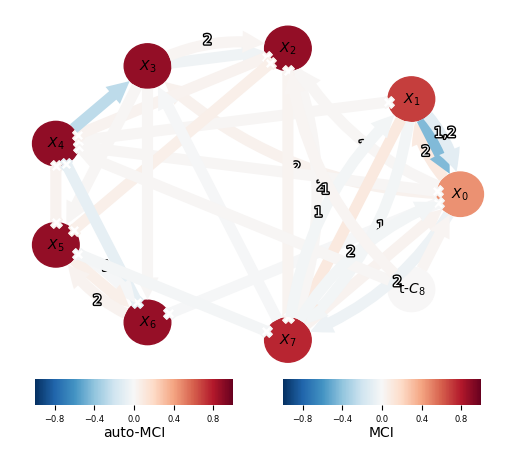

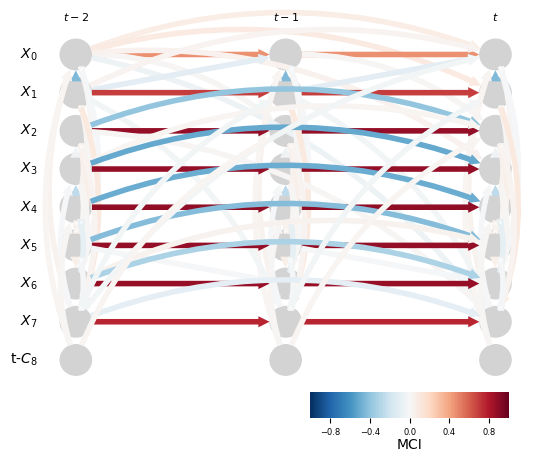

In [76]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
tp.plot_time_series_graph(results['graph'], val_matrix = results['val_matrix'], 
              node_classification = node_classification_jpcmci, var_names=var_names)
plt.show()